# Chess Winner Prediction Using ML Models 

The goal is to predict chess matches winner using the available data from lichess dataset. And also, what is the impact of the opening (strategy and turns taken) in winning the game. You can inspect and download the dataset from [this url](https://www.kaggle.com/datasets/datasnaek/chess).

**TODO: Improve introduction**

**TODO: understand scikit-learn pipelines. [ref_1](https://scikit-learn.org/stable/modules/compose.html#pipeline), [ref_2](https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9)**

## About Dataset

Extracted from official dataset index.

**General Info**

This is a set of just over 20,000 games collected from a selection of users on the site Lichess.org, and how to collect more. This set contains the following features:


- Game ID;
- Rated (T/F);
- Start Time;
- End Time;
- Number of Turns;
- Game Status;
- Winner;
- Time Increment;
- White Player ID;
- White Player Rating;
- Black Player ID;
- Black Player Rating;
- All Moves in Standard Chess Notation;
- Opening Eco (Standardised Code for any given opening, [list here](https://www.365chess.com/eco.php));
- Opening Name;
- Opening Ply (Number of moves in the opening phase)

Data was collected using the [Lichess API](https://github.com/ornicar/lila), which enables collection of any given users game history.

**Possible Uses**

Lots of information is contained within a single chess game, let alone a full dataset of multiple games. It is primarily a game of patterns, and data science is all about detecting patterns in data, which is why chess has been one of the most invested in areas of AI in the past. This dataset collects all of the information available from 20,000 games and presents it in a format that is easy to process for analysis of, for example, what allows a player to win as black or white, how much meta (out-of-game) factors affect a game, the relationship between openings and victory for black and white and more.

## Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# only on notebooks
%matplotlib inline

## Loading, exploring and preprocessing data

In [3]:
chess = pd.read_csv('games.csv')

In [4]:
chess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


### Dropping unused columns

Some features, like unique match and player's ```id```, if match was ```rated``` or not, and timestamps are not useful to us. Therefore, they must be removed. Also, ```moves``` can result in some sort of data leakage, and will be removed aswell.

In [5]:
chess = chess.drop(['id', 'rated', 'created_at', 'last_move_at', 'increment_code', 'white_id', 'black_id', 'opening_name', 'moves'], axis=1)
chess.head()

,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply
0,13,outoftime,white,1500,1191,D10,5
1,16,resign,black,1322,1261,B00,4
2,61,mate,white,1496,1500,C20,3
3,61,mate,white,1439,1454,D02,3
4,95,mate,white,1523,1469,C41,5


In [6]:
chess.describe()

,turns,white_rating,black_rating,opening_ply
count,20058.000000,20058.000000,20058.000000,20058.000000
mean,60.465999,1596.631868,1588.831987,4.816981
std,33.570585,291.253376,291.036126,2.797152
min,1.000000,784.000000,789.000000,1.000000
25%,37.000000,1398.000000,1391.000000,3.000000
50%,55.000000,1567.000000,1562.000000,4.000000
75%,79.000000,1793.000000,1784.000000,6.000000
max,349.000000,2700.000000,2723.000000,28.000000


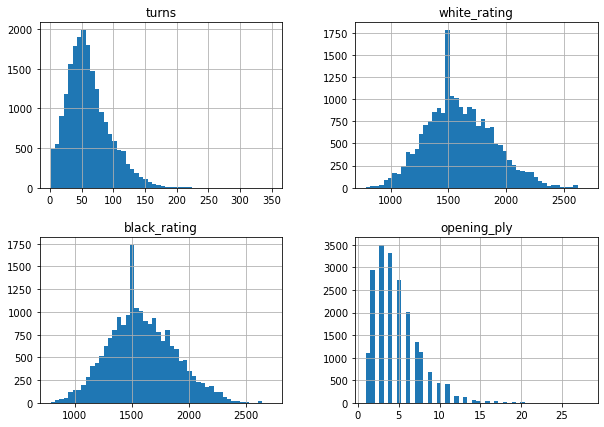

In [7]:
chess.hist(bins=50, figsize=(10,7))
plt.show()

In [8]:
chess['opening_eco'].unique().size

365

# TODO: Group ECO by cat
https://en.wikipedia.org/wiki/Encyclopaedia_of_Chess_Openings

In [42]:
chess['opening_eco'][chess['opening_eco'].str.startswith('A')]

10       A00
21       A40
23       A25
37       A45
39       A21
52       A80
53       A20
54       A04
61       A40
62       A40
65       A04
66       A45
70       A41
71       A45
75       A40
82       A10
83       A00
85       A40
94       A47
95       A40
112      A46
119      A43
120      A08
137      A20
155      A46
157      A56
168      A40
173      A45
193      A00
195      A00
207      A40
209      A42
215      A00
226      A22
230      A06
231      A04
240      A00
241      A22
256      A07
257      A10
263      A02
266      A00
269      A03
288      A31
289      A00
295      A40
298      A03
299      A03
306      A00
307      A02
310      A02
312      A02
314      A00
316      A45
320      A00
339      A00
348      A05
352      A45
356      A49
360      A04
363      A09
366      A01
369      A00
370      A20
375      A00
388      A00
390      A00
393      A00
400      A46
403      A00
405      A00
409      A01
416      A00
422      A40
432      A45
435      A80
438      A40

In [9]:
print(chess['winner'].unique())
print(chess['winner'].unique().size)

['white' 'black' 'draw']
3


In [10]:
print(chess['victory_status'].unique())
print(chess['victory_status'].unique().size)

['outoftime' 'resign' 'mate' 'draw']
4


### One-Hot Encoding Categorical Variables

In [11]:
# https://www.statology.org/one-hot-encoding-in-python/
from sklearn.preprocessing import OneHotEncoder

def cat_encoder(df, var_array):
    encoded, categories = var_array.factorize()
    print('first values: ')
    print(encoded[:10])
    print(categories)
    encoder = OneHotEncoder()
    one_hot = encoder.fit_transform(encoded.reshape(-1, 1))
    one_hot_df = pd.DataFrame(one_hot.toarray())
    return df.join(one_hot_df)

In [12]:
chess = cat_encoder(chess, chess['winner'])
chess

first values: 
[0 1 0 0 0 2 0 1 1 0]
Index(['white', 'black', 'draw'], dtype='object')


,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,0,1,2
0,13,outoftime,white,1500,1191,D10,5,1.0,0.0,0.0
1,16,resign,black,1322,1261,B00,4,0.0,1.0,0.0
2,61,mate,white,1496,1500,C20,3,1.0,0.0,0.0
3,61,mate,white,1439,1454,D02,3,1.0,0.0,0.0
4,95,mate,white,1523,1469,C41,5,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
20053,24,resign,white,1691,1220,A80,2,1.0,0.0,0.0
20054,82,mate,black,1233,1196,A41,2,0.0,1.0,0.0
20055,35,mate,white,1219,1286,D00,3,1.0,0.0,0.0
20056,109,resign,white,1360,1227,B07,4,1.0,0.0,0.0


In [13]:
# keeping winner bcause its our y
chess.rename({0: 'white_wins', 1: 'black_wins', 2: 'draw'}, axis=1, inplace=True)

Dropping draw column to avoid redundancy

In [14]:
chess.drop(['draw'], axis=1, inplace=True)

In [15]:
chess.head()

,turns,victory_status,winner,white_rating,black_rating,opening_eco,opening_ply,white_wins,black_wins
0,13,outoftime,white,1500,1191,D10,5,1.0,0.0
1,16,resign,black,1322,1261,B00,4,0.0,1.0
2,61,mate,white,1496,1500,C20,3,1.0,0.0
3,61,mate,white,1439,1454,D02,3,1.0,0.0
4,95,mate,white,1523,1469,C41,5,1.0,0.0


In [16]:
print(chess['victory_status'].unique())
print(chess['victory_status'].unique().size)

['outoftime' 'resign' 'mate' 'draw']
4


In [17]:
chess = cat_encoder(chess, chess['victory_status'])
chess.drop('victory_status', axis=1, inplace=True)
chess.rename({0: 'outoftime', 1: 'resign', 2: 'mate', 3: 'draw'}, axis=1, inplace=True)

first values: 
[0 1 2 2 2 3 1 1 1 2]
Index(['outoftime', 'resign', 'mate', 'draw'], dtype='object')


In [18]:
chess.head()

,turns,winner,white_rating,black_rating,opening_eco,opening_ply,white_wins,black_wins,outoftime,resign,mate,draw
0,13,white,1500,1191,D10,5,1.0,0.0,1.0,0.0,0.0,0.0
1,16,black,1322,1261,B00,4,0.0,1.0,0.0,1.0,0.0,0.0
2,61,white,1496,1500,C20,3,1.0,0.0,0.0,0.0,1.0,0.0
3,61,white,1439,1454,D02,3,1.0,0.0,0.0,0.0,1.0,0.0
4,95,white,1523,1469,C41,5,1.0,0.0,0.0,0.0,1.0,0.0


### Further exploring

In [19]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(chess, test_size=0.2, random_state=42)

In [20]:
exp_chess = train_set.copy()

In [21]:
corr_matrix = exp_chess.corr()

In [22]:
corr_matrix['white_wins'].sort_values(ascending=False)

white_wins      1.000000
white_rating    0.126157
resign          0.060981
mate            0.037387
opening_ply     0.013721
outoftime      -0.009369
turns          -0.075366
black_rating   -0.171295
draw           -0.216829
black_wins     -0.909616
Name: white_wins, dtype: float64

In [23]:
corr_matrix['black_wins'].sort_values(ascending=False)

black_wins      1.000000
black_rating    0.155364
resign          0.045273
mate            0.026566
outoftime       0.023183
turns           0.007362
opening_ply    -0.021261
white_rating   -0.146594
draw           -0.198514
white_wins     -0.909616
Name: black_wins, dtype: float64

**Exploratory assumptions**: 
* It's easier to win on white side, even if you are outranked by your opponent.
* The most common method to win is ```resign```.
* Black have better chances on longer games, winning by ```outoftime```.
* Simetrically, white have better chances on short ```opening_ply```.
* The longer the game, more chances black have to win.


### Finishing dataset exploration

In [24]:
chess.drop(['white_wins', 'black_wins'], axis=1, inplace=True)

chess

,turns,winner,white_rating,black_rating,opening_eco,opening_ply,outoftime,resign,mate,draw
0,13,white,1500,1191,D10,5,1.0,0.0,0.0,0.0
1,16,black,1322,1261,B00,4,0.0,1.0,0.0,0.0
2,61,white,1496,1500,C20,3,0.0,0.0,1.0,0.0
3,61,white,1439,1454,D02,3,0.0,0.0,1.0,0.0
4,95,white,1523,1469,C41,5,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
20053,24,white,1691,1220,A80,2,0.0,1.0,0.0,0.0
20054,82,black,1233,1196,A41,2,0.0,0.0,1.0,0.0
20055,35,white,1219,1286,D00,3,0.0,0.0,1.0,0.0
20056,109,white,1360,1227,B07,4,0.0,1.0,0.0,0.0


In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
chess['winner'] = le.fit_transform(chess['winner'])
# 2: white, 0: black, 1:draw

chess

ValueError: not enough values to unpack (expected 4, got 2)

## Splitting Dataset using Holdout Method 

In [31]:
chess_x = chess.loc[:, chess.columns != 'winner']
chess_x

,turns,white_rating,black_rating,opening_eco,opening_ply,outoftime,resign,mate,draw
0,13,1500,1191,D10,5,1.0,0.0,0.0,0.0
1,16,1322,1261,B00,4,0.0,1.0,0.0,0.0
2,61,1496,1500,C20,3,0.0,0.0,1.0,0.0
3,61,1439,1454,D02,3,0.0,0.0,1.0,0.0
4,95,1523,1469,C41,5,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
20053,24,1691,1220,A80,2,0.0,1.0,0.0,0.0
20054,82,1233,1196,A41,2,0.0,0.0,1.0,0.0
20055,35,1219,1286,D00,3,0.0,0.0,1.0,0.0
20056,109,1360,1227,B07,4,0.0,1.0,0.0,0.0


In [33]:
chess_y = chess['winner']
chess_y

0        2
1        0
2        2
3        2
4        2
        ..
20053    2
20054    0
20055    2
20056    2
20057    0
Name: winner, Length: 20058, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(chess_x, chess_y, test_size=0.2, random_state=42)

## Selecting and Training Models

We'll startoff with a simple Linear Regression model.

In [36]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

ValueError: could not convert string to float: 'C02'